# Multipeak distributions

## Introduction

This notebook setup a framework for creating a multipeak distribution (MultiPeakDistribution) composed by the sum of scipy distributions, a MultiPeakModel where a sum of scipy distributions can be fitted to observations (events) using Maximum Likelihood Estimation

In [1]:
from scipy.stats import distributions as scidists
from scipy.stats import fit as scifit
from scipy.optimize import minimize, LinearConstraint
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

In [2]:
class MultiPeakDistribution:
    """
    Class for creating multipeak distributions from a sum of weighted scipy distributions where each is defined by 
    a 'loc' and 'scale' parameter
    
    """
    
    def __init__(self, dists, locs, scales, weights):
        """
        aaa
        """
        
        # TODO consider dists to be a list of dist instances 
        
        self._dists = dists

        self._locs = locs
        self._scales = scales
        
        # normalize weights
        self._weights = np.array(weights)/np.sum(weights)

        self._frozen_dists = [dist(loc, scale) for dist, loc, scale in zip(self._dists, self._locs, self._scales)]

    
    def get_frozen_dists(self):
        return self._frozen_dists
    
    def get_weights(self):
        return self._weights
    
    def pdf(self, x):
        pdfs = [dist.pdf(x) for dist in self._frozen_dists]
        return np.dot(self._weights, pdfs)
    
    def rvs(self, size):
        dselections_indexes = np.random.choice(np.arange(len(self._frozen_dists)), size=size, 
                                               replace=True, p=self._weights, )
        indexes, counts = np.unique(dselections_indexes, return_counts=True)
        rvs = np.concatenate(
                    [self._frozen_dists[ind].rvs(size=count) for ind, count in zip(indexes, counts)],
            axis=0)
        np.random.shuffle(rvs)
        return rvs
    

In [3]:
class MultiPeakModel:

        def __init__(self, events, dists, initial_locs, initial_scales, initial_weights):
            self._dists = dists
            self._events = events
            self.initial_locs = initial_locs
            self.initial_scales = initial_scales
            self.initial_weights = initial_weights/np.sum(initial_weights)
            
        def nloglikeobs(self, params):
            params.shape = (3, -1)
            mpeak = MultiPeakDistribution(self._dists, *params)
            pdfs = mpeak.pdf(self._events)
            return -np.sum(np.log(mpeak.pdf(self._events)))
        
        def nlikeobs(self, params):
            params.shape = (3, -1)
            mpeak = MultiPeakDistribution(self._dists, *params)
            pdfs = mpeak.pdf(self._events)
            return -np.prod(mpeak.pdf(self._events))
        
        def fit(self, initial_locs=None, initial_scales=None, initial_weights=None, method='BFGS', 
                log=False, constraints=(), param_tol=1e-6):
            """
            Fit the parameters for a
            
            """
            
            # Reset parameters if requested, i.e., provided as arguments to this method
            for key in ['initial_locs', 'initial_scales', 'initial_weights']: 
                value = np.asarray(eval(key))
                if value.all() != None:
                    setattr(self, key, value)
                elif value.any() != None:
                    raise("WARNING: All values of {} must be defined to reset initial parameters Current value is {}={}".format(key, key, value))
                else:
                    pass
            
            # format parameters for the minimize and target function
            initial_params = np.concatenate([self.initial_locs, self.initial_scales, self.initial_weights/np.sum(self.initial_weights)])
            
            if log is True:
                target_func = self.nloglikeobs
            else:
                target_func = self.nlikeobs
            return minimize(target_func, x0=initial_params, args = (), method=method, constraints=constraints)
            


In [4]:
# common constraints

class NormConstraint:
    
    def __init__(self, n_params):
        self.nweights = int(n_params/3)
        self.n_other = n_params - self.nweights
        
        # lower bounds for each weight 
        self.lowerbounds =  np.zeros(self.nweights+1)
        # lower bound for norm (sum of weights)
        self.lowerbounds[-1] = 1
        # upper bounds for each weight and norm
        self.upperbounds = np.ones(self.nweights+1)
        
        
        self.A_other = np.zeros([self.nweights+1, self.n_other])
        self.A_iweights = np.identity(self.nweights)
        self.A_norm = np.ones([1, self.nweights])
        self.A_weights = np.concatenate([self.A_iweights, self.A_norm], axis=0)
        self.A = np.concatenate([self.A_other, self.A_weights], axis=1)
        
        
    def __call__(self):
        return LinearConstraint(self.A, lb=self.lowerbounds, ub=self.upperbounds)
        
        
class ScaleConstraints:
    
    def __init__(self, n_params):
        self.nscales = int(n_params/3)
        self.lowerbounds = np.zeros(self.nscales)
        self.upperbounds = np.inf*np.ones(self.nscales)
        self.A = np.concatenate( [np.zeros([self.nscales,self.nscales]), 
                                  np.identity(self.nscales), 
                                  np.zeros([self.nscales,self.nscales])], 
                                axis=1 )
        
    def __call__(self):
        return LinearConstraint(self.A, lb=self.lowerbounds, ub=self.upperbounds)
    

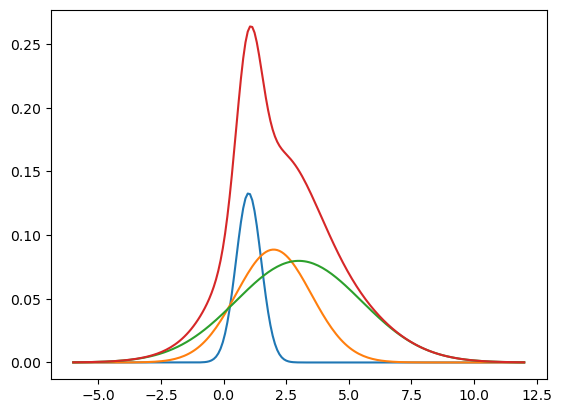

In [5]:
npeaks = 3

distributions = npeaks*[scidists.norm]

locations = np.arange(npeaks) + 1.

scales = np.arange(npeaks) + 0.5

weights = np.arange(npeaks) + 1.

np.random.seed(333)
dev = 1.*(np.random.random_sample(npeaks)-0.5)

#iloc = np.linspace(0.,5., npeaks)
iloc = locations + dev

#iscale = np.ones(npeaks)
iscale = scales + dev

#iweights = np.ones(npeaks)
iweights = weights + dev

multi_peak = MultiPeakDistribution(distributions, locations, scales, weights)

peaks = multi_peak.get_frozen_dists()

xrange = [-6,12]

xgrid = np.linspace(*xrange, 200)

dx = (xrange[1] - xrange[0])/len(xgrid)

for w, peak in zip(weights, peaks):
    plt.plot(xgrid, w*peak.pdf(xgrid)/np.sum(weights) )
    
plt.plot(xgrid, multi_peak.pdf(xgrid))


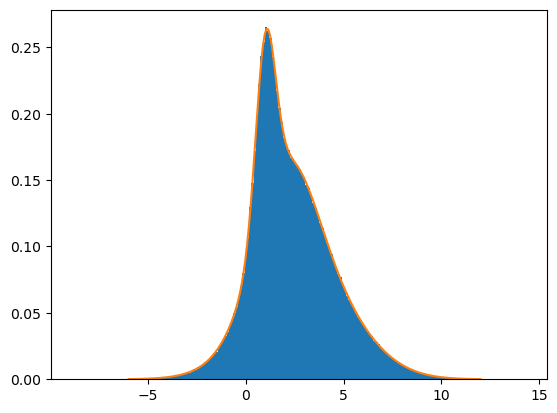

In [6]:
rvs = multi_peak.rvs(1000000)

hist = plt.hist(rvs, bins=200, density=True)
plt.plot(xgrid, multi_peak.pdf(xgrid))

In [7]:
fitmodel = MultiPeakModel(multi_peak.rvs(10000), distributions, iloc, iscale, iweights)

In [8]:
result1 = fitmodel.fit(method='Nelder-Mead', log=True)
print(result1)

params = np.concatenate([locations, scales, weights/np.sum(weights)])

diff1 = result1.x - params

rms1 = np.sqrt(np.sum(diff1**2))

print("DIFF", diff1)

print("RMS", rms1)

print("Norm", np.sum(result1.x[-len(weights):]))


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21155.947749843
             x: [ 9.776e-01  1.994e+00  3.004e+00  4.645e-01  1.495e+00
                  2.507e+00  1.715e-01  3.760e-01  5.265e-01]
           nit: 465
          nfev: 703
 final_simplex: (array([[ 9.776e-01,  1.994e+00, ...,  3.760e-01,
                         5.265e-01],
                       [ 9.776e-01,  1.994e+00, ...,  3.760e-01,
                         5.264e-01],
                       ...,
                       [ 9.776e-01,  1.994e+00, ...,  3.760e-01,
                         5.265e-01],
                       [ 9.776e-01,  1.994e+00, ...,  3.759e-01,
                         5.265e-01]]), array([ 2.116e+04,  2.116e+04,  2.116e+04,  2.116e+04,
                        2.116e+04,  2.116e+04,  2.116e+04,  2.116e+04,
                        2.116e+04,  2.116e+04]))
DIFF [-0.02237881 -0.00648696  0.00409895 -0.0355225  -0.00460886  0.00680572
  0.00485

In [9]:
result2 = fitmodel.fit(method='Nelder-Mead', log=False)
print(result2)


diff2 = result2.x - params

rms2 = np.sqrt(np.sum(diff2**2))

print("DIFF", diff2)

print("RMS", rms2)

print("Norm", np.sum(result2.x[-len(weights):]))


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.0
             x: [ 1.043e+00  2.229e+00  2.517e+00  5.433e-01  1.729e+00
                  2.017e+00  1.802e-01  3.850e-01  4.348e-01]
           nit: 12
          nfev: 131
 final_simplex: (array([[ 1.043e+00,  2.229e+00, ...,  3.850e-01,
                         4.348e-01],
                       [ 1.043e+00,  2.229e+00, ...,  3.850e-01,
                         4.348e-01],
                       ...,
                       [ 1.043e+00,  2.229e+00, ...,  3.850e-01,
                         4.348e-01],
                       [ 1.043e+00,  2.229e+00, ...,  3.850e-01,
                         4.348e-01]]), array([-0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00,
                       -0.000e+00, -0.000e+00, -0.000e+00, -0.000e+00,
                       -0.000e+00, -0.000e+00]))
DIFF [ 0.04329109  0.22895073 -0.48311855  0.04329109  0.22895073 -0.48311855
  0.01354907  0.05169

In [10]:
norm_constraint = NormConstraint(3*npeaks)
norm_scales = ScaleConstraints(3*npeaks)

result3 = fitmodel.fit(method='trust-constr', log=True, constraints=(norm_constraint(), norm_scales()))
print(result3)


diff3 = result3.x - params

rms3 = np.sqrt(np.sum(diff3**2))

print("DIFF", diff3)

print("RMS", rms3)

print("Norm", np.sum(result3.x[-len(weights):]))


/Users/thomasholmrod/opt/anaconda3/envs/emtk/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 21155.947749273004
                 x: [ 9.776e-01  1.994e+00  3.004e+00  4.645e-01  1.495e+00
                      2.507e+00  1.597e-01  3.501e-01  4.902e-01]
               nit: 162
              nfev: 1680
              njev: 168
              nhev: 0
          cg_niter: 710
      cg_stop_cond: 4
              grad: [ 2.441e-04  1.225e-04  8.127e-05  2.441e-04  1.633e-04
                      9.739e-05  2.441e-04  4.883e-04  2.441e-04]
   lagrangian_grad: [ 2.441e-04  1.225e-04  8.127e-05  4.332e-05  1.128e-04
                      8.402e-05 -2.295e-06  1.290e-05 -1.060e-05]
            constr: [array([ 1.597e-01,  3.501e-01,  4.902e-01,  1.000e+00]), array([ 4.645e-01,  1.495e+00,  2.507e+00])]
               jac: [array([[ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  0.000e+00

In [11]:

result4 = fitmodel.fit(method='trust-constr', log=False, constraints=(norm_constraint(), norm_scales()))
print(result4)


diff4 = result4.x - params

rms4 = np.sqrt(np.sum(diff4**2))

print("DIFF", diff4)

print("RMS", rms4)

print("Norm", np.sum(result4.x[-len(weights):]))


           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.0
                 x: [ 1.043e+00  2.229e+00  2.517e+00  8.025e-01  1.844e+00
                      2.119e+00  2.821e-01  3.514e-01  3.665e-01]
               nit: 14
              nfev: 40
              njev: 4
              nhev: 0
          cg_niter: 4
      cg_stop_cond: 0
              grad: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                      0.000e+00  0.000e+00  0.000e+00  0.000e+00]
   lagrangian_grad: [ 0.000e+00  0.000e+00  0.000e+00 -4.999e-09 -4.291e-09
                     -3.952e-09 -4.497e-10  1.493e-10  3.003e-10]
            constr: [array([ 2.821e-01,  3.514e-01,  3.665e-01,  1.000e+00]), array([ 8.025e-01,  1.844e+00,  2.119e+00])]
               jac: [array([[ 0.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  0.000e+00, ...,  1.000e+00,
  

/Users/thomasholmrod/opt/anaconda3/envs/emtk/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
